### Importing the Necessary Libraries for implementing the DL Model

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.utils import image_dataset_from_directory
from keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D, Dropout, Flatten, Conv2D
from keras.layers import Rescaling, RandomRotation, RandomContrast, RandomZoom
from keras.utils import plot_model
from keras.applications.densenet import DenseNet121
from keras import Model, Sequential

### Splitting the dataset into Training Set and Test Set

In [8]:
trainDataset = image_dataset_from_directory(
    directory = "./Datasets/COVID_19_Chest_CT_1/",
    labels = "inferred",
    label_mode = "categorical",
    color_mode = "rgb",
    image_size = (224, 224),
    validation_split = 0.2,
    subset = "training",
    batch_size = 32,
    seed = 42,
    interpolation = "bilinear"
)

testDataset = image_dataset_from_directory(
    directory = "./Datasets/COVID_19_Chest_CT_1/",
    labels = "inferred",
    label_mode = "categorical",
    color_mode = "rgb",
    image_size = (224, 224),
    validation_split = 0.2,
    subset = "validation",
    batch_size = 32,
    seed = 42,
    interpolation = "bilinear"
)

print(trainDataset.class_names)

Found 2481 files belonging to 2 classes.
Using 1985 files for training.
Found 2481 files belonging to 2 classes.
Using 496 files for validation.
['COVID', 'non-COVID']


### Visualizing the Image Dataset

(32, 224, 224, 3)


TypeError: only integer scalar arrays can be converted to a scalar index

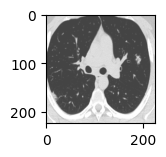

In [12]:
trainImages, trainLabels = next(iter(trainDataset))
print(trainImages.shape)
for i in range(9) :
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(trainImages[i].numpy().astype("uint8"))
    plt.title(trainDataset.class_names[trainLabels[i]])
    plt.axis("off")

### Building the Model

In [ ]:
denseModel = DenseNet121(include_top = False, weights = 'imagenet', input_shape = (224, 224, 3))
hybridModel = denseModel.output
hybridModel = GlobalAveragePooling2D()(hybridModel)
hybridModel = Dropout(rate = 0.5)(hybridModel)
hybridModel = Dense(units = 1024, activation = "relu")(hybridModel)
hybridModel = Dense(units = 512, activation = "relu")(hybridModel)
hybridModel = Dropout(rate = 0.5)(hybridModel)
hybridModel = Dense(units = 2, activation = "softmax")(hybridModel)

In [ ]:
model = Model(inputs = denseModel.input, outputs = denseModel.output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [ ]:
for layer in model.layers[:-8]:
    layer.trainable = False

for layer in model.layers[-8:]:
    layer.trainable = True

In [ ]:
imgFile = './Plot_Images/Model_Architecture.png'
plot_model(model, imgFile, show_shapes = True)

In [ ]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), loss = keras.losses.BinaryCrossentropy(), metrics = [keras.metrics.BinaryAccuracy(), keras.metrics.AUC(), keras.metrics.Accuracy()])
modelHistory = model.fit(x = trainDataset, epochs = 10, verbose = "auto", validation_data = (testDataset))

Epoch 1/10
45/63 [====================>.........] - ETA: 8:18 - loss: 0.3957 - binary_accuracy: 0.4979 - auc_1: 0.5000 - accuracy: 0.4979